# Overview

This project applies machine learning to mechanical systems that are monitored by sensory data. With machine learning operation of complicated equipment can help optimize efficiency and utilization of resources. Very often, the data is already being collected but as of right now, it is highly under utilized. 

In this project we'll look at a synthetic lubricant system that supports a solar power plant in the desert. These systems supply lubricant to systems within a power plant and require maintenance at predetermined alarm points. We'll use machine learning in a real-world application for predicting performance based on several external parameters. With this model, we can effectivy make decisions on equipment operation and scheduled maintenance.

## Generate the data

We will develop our own data set applying some basic laws of physics. In the end, this data will be representative of raw data that may be collected from sensors on actual equipment used to make every day operating decisions.

In this example, we'll consider the following sensory data:

1. Ambient Temperature
2. Accumulator Pressure
3. Pump Flow Rate

Why these 3 parameters? Our accumulator system has a positive pressure applied to it which results in slow consumption of lubricant over time. This pressure fluctuates with ambient temperature as desert extremes can vary to freezing and exceeding 100 F during the summer. The demand on the pump my vary throughout its operating which generally results in a various consumption rats. This affects the rate of leakage and how often the system must be serviced for maintenance. We'll look at preciting future system performance based on past equipment data and ambient data that was collected to develop a model.

### Generating Ambient Temperature Data

Solar plants are often in the desert of the Southwest USA. In this example, we'll be looking at ambient temperatures in Palm Springs for instance. It get's much cooler in the winter months which can affect performance of the system we are simulating. We'll start with this data to being developing our own dataset to experiment with.

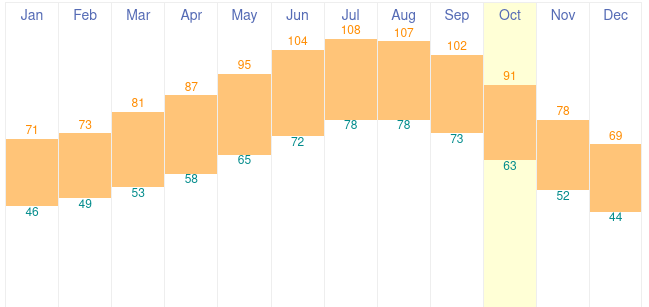



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
# Develop data over 2 yearswith temperatures recorded every 2 hours or 12 data points per day.
# Total of 8750 data points

readings_per_day = 12
days_in_month = 30
months = 24

time = np.arange(months * days_in_month * readings_per_day)
print(len(time))
# Create min and max arrays for monthly averages
min_temps = [46.0,49.0,53.0,58.0,65.0,72.0,78.0,78.0,73.0,63.0,52.0,44.0]
max_temps = [71.0,73.0,81.0,87.0, 95.0,104.0,108.0,107.0,102.0,91.0,78.0,69.0]

8640


In [2]:
def trend(time, slope=0):
    return slope * time

series = trend(time,slope=0)

# Now add the averages tempers to the reasonable seasonality and variation.
window = readings_per_day * days_in_month
for month in range(len(min_temps)):
    avg_temp = (min_temps[month]+max_temps[month])/2.0
    series[month*window:(month+1)*window] = avg_temp
    # Duplicate for 2nd year
    series[12*window:] = series[0:12*window]

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.8,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

temps = series + seasonality(time,period=12,amplitude=12,phase=6) + noise(time,noise_level=2,seed=15)


Text(0.5, 1.0, '5 Days of Data')

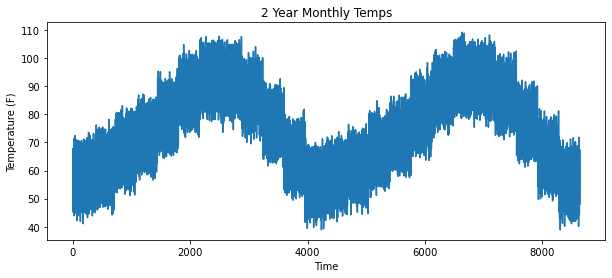

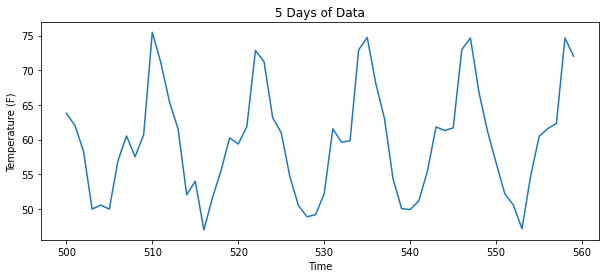

In [3]:
plt.figure(figsize=(10,4))
plt.plot(time,temps)
plt.ylabel("Temperature (F)")
plt.xlabel("Time")
plt.title("2 Year Monthly Temps")

plt.figure(figsize=(10,4))
plt.plot(time[500:560],temps[500:560])
plt.ylabel("Temperature (F)")
plt.xlabel("Time")
plt.title("5 Days of Data")

### Generate Pump Flow Rate Data¶

Next we'll generate pump flow rate data. In the case of a pump, flow and pressure are related. How these parameters vary often affects how the mechanical support system operates. The change in pump flow, varies the consumption of the sythetic lubricant. We'll generate 3 different operating flow rates that will last a few months at a time. We'll scatter in 0 gpm indicating the equipment is in standby and not operating. During this period, there is very little consumption of the synthetic lubricant since the equipment is not operating.

In [3]:
def gen_flow(time):
    flows = (0,5000,8000) # gpm
    series = trend(time,slope=0)
    index=0
    while(index<len(time)):
        duration = np.random.randint(low=2,high=4)
        x = np.random.randint(low=0,high=3)
        series[index:index+(duration*30*12)] = int(flows[x])
        index = duration*30*12 + index
    return series

flows = gen_flow(time)

Text(0.5, 1.0, 'Flow Rate of Pump over 2 Years')

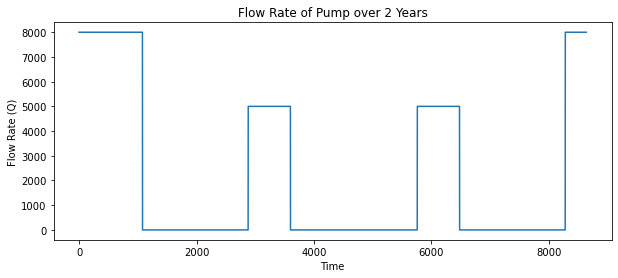

In [4]:
plt.figure(figsize=(10,4))
plt.plot(time,flows)
plt.ylabel("Flow Rate (Q)")
plt.xlabel("Time")
plt.title("Flow Rate of Pump over 2 Years")

### Generate Support System Pressure

Lastly we need to generate system pressure which will be dependent on the operation of the pump and the ambient temperatures. In practice, a high and low alarm is set to indentify when the system needs intervention. A high alarm indicates there is too much pressure in the system which may result in damage. A low alarm means, the system needst to be refilled and the synthetic lubricant is near empty. In this example, we'll give us a 25 psi operating window. At the initial fill of the this support system, we'll say the system was primed to 60 psi. The alarms are then at 70 psi and 40 psi for the low alarm. The system pressure will vary with ambient temperature and leakage will occur over time based on the operation of the equipment. We are generating this data but in the field, this information would be collected and fed into a neural network in order to predict future performance to schedule and monitor system maintenance.

In [5]:
psi = trend(time,0)
psi = psi + 60.0
print("Type psi[0]:",type(psi[0]))
leak_rate = {0:.002,5000:.042,8000:.083} #leak per data pt
print("Temp at time 0:",temps[0])

for index in range(len(time)):
    #print(leak_rate[flows[index]])
    #print("Index:",index)
    #print("Leak rate:",leak_rate[flows[index]])
    #print("Current psi:",psi[index])
    psi[index+1] = psi[index]*((temps[index+1]+459)/(temps[index]+459)) - leak_rate[flows[index]]
    #print("Next psi:", psi[index+1])
    if(psi[index+1]<35.0):
        psi[index+1]=60.0
    
    if(index==(len(time)-2)):
        break

Type psi[0]: <class 'numpy.float64'>
Temp at time 0: 45.37534303691291


Text(0.5, 1.0, 'System Pressure over 5 Days')

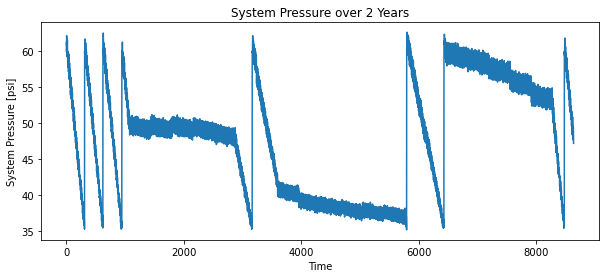

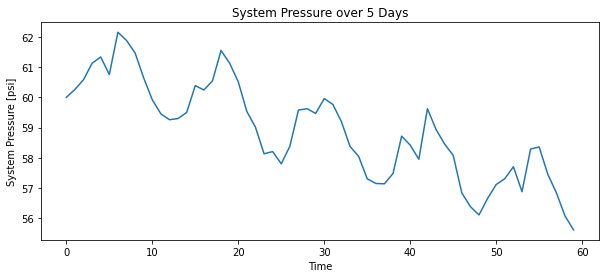

In [6]:
plt.figure(figsize=(10,4))
plt.plot(time,psi)
plt.ylabel("System Pressure [psi]")
plt.xlabel("Time")
plt.title("System Pressure over 2 Years")

plt.figure(figsize=(10,4))
plt.plot(time[:60],psi[:60])
plt.ylabel("System Pressure [psi]")
plt.xlabel("Time")
plt.title("System Pressure over 5 Days")

We can see the slow drop in system pressure during standby periods and the more periodic pressure variation during normal operating conditions.

Now we've generated all the data to form out dataset that can be fed into a neural network. We'll make sure all the data is the same length and plot create subplots to view the data. This generated data accounts for meausrements taken every 2 hours, so we have 12 measurements in a single day. The full data set represents 2 years of operation. High speed equipment data is often recorded at a much higher frequency. 

In [7]:
print("Length of time:",len(time))
print("Length of temps:",len(temps))
print("Length of flows:",len(flows))
print("Length of psi:",len(psi))

Length of time: 8640
Length of temps: 8640
Length of flows: 8640
Length of psi: 8640


Text(0, 0.5, 'System Pressure')

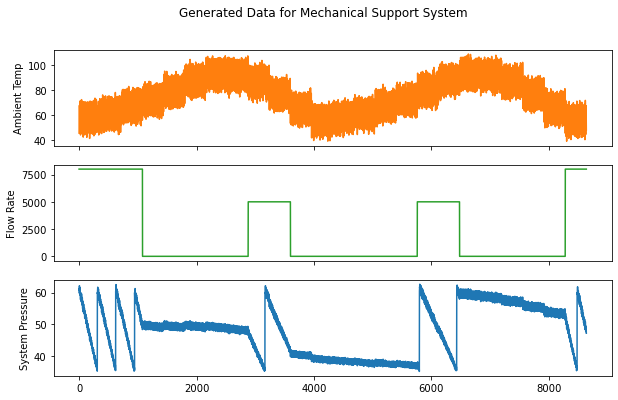

In [8]:
fig,axs = plt.subplots(3,sharex=True,figsize=(10,6))
fig.suptitle("Generated Data for Mechanical Support System")
axs[0].plot(time,temps,'tab:orange')
axs[0].set_ylabel("Ambient Temp")
axs[1].plot(time,flows,'tab:green')
axs[1].set_ylabel("Flow Rate")
axs[2].plot(time,psi)
axs[2].set_ylabel("System Pressure")

### Generate Dataframe

Now we'll combine all the series into a dataframe uisng the Pandas library

In [9]:
import pandas as pd

In [10]:
print(type(time))
df=pd.DataFrame({'Temp':temps,'Flow Rate':flows,'Pressure':psi})


<class 'numpy.ndarray'>


In [11]:
df.head(5)

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temp,8640.0,73.444772,15.078564,38.863788,61.533945,73.210940,85.004789,109.234050
Flow Rate,8640.0,2166.666667,3184.346480,0.000000,0.000000,0.000000,5000.000000,8000.000000
Pressure,8640.0,47.797815,7.702284,35.130703,39.445833,48.726773,54.580927,62.645916


In [12]:
#sys_csv_data = df.to_csv('../data/long_sys_data.csv',index=False) 

## Preparing the Data

First we'll split the data into 70%,20% and 10% for training,validation,testing.

In [13]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print("Number of features:",num_features)
val_df.head()

Number of features: 3


,Temp,Flow Rate,Pressure
6048,68.973729,5000,50.052727
6049,70.557262,5000,50.160848
6050,71.721746,5000,50.229151
6051,81.997915,5000,51.159719
6052,79.605553,5000,50.891485


Next we are going to normalize the data prior to feeding it into the model. We'll simplify the normalization by using the mean and standard deviation of the training data only to ensure there is no information of future data used. Alternatively we could use the moving average for the parameters.

In [14]:
# Standard deviation and mean for Temp and Pressure
train_temp_mean = train_df['Temp'].mean()
train_temp_std = train_df['Temp'].std()

train_psi_mean = train_df['Pressure'].mean()
train_psi_std = train_df['Pressure'].std()
# Flow will be devided by the max of 8000

# Normalize training data
train_df['Temp'] = (train_df['Temp'] - train_temp_mean) / train_temp_std
train_df['Flow Rate'] = train_df['Flow Rate'] / 8000
train_df['Pressure'] = (train_df['Pressure'] - train_psi_mean) / train_psi_std

# Normalize validation data
val_df['Temp'] = (val_df['Temp'] - train_temp_mean) / train_temp_std
val_df['Flow Rate'] = val_df['Flow Rate'] / 8000
val_df['Pressure'] = (val_df['Pressure'] - train_psi_mean) / train_psi_std

# Normalize test data
test_df['Temp'] = (test_df['Temp'] - train_temp_mean) / train_temp_std
test_df['Flow Rate'] = test_df['Flow Rate'] / 8000
test_df['Pressure'] = (test_df['Pressure'] - train_psi_mean) / train_psi_std

# Normaize Data Frame
df['Temp'] = (df['Temp'] - train_temp_mean) / train_temp_std
df['Flow Rate'] = df['Flow Rate'] / 8000
df['Pressure'] = (df['Pressure'] - train_psi_mean) / train_psi_std


<ipython-input-14-69cb2e794f80>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Temp'] = (train_df['Temp'] - train_temp_mean) / train_temp_std
<ipython-input-14-69cb2e794f80>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Flow Rate'] = train_df['Flow Rate'] / 8000
<ipython-input-14-69cb2e794f80>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Now we can see the data is normalized at has much smaller float representation that can be fed into the neural network.

In [15]:
val_df.head()

,Temp,Flow Rate,Pressure
6048,-4.950040,0.625,-6.543623
6049,-4.942437,0.625,-6.541291
6050,-4.936846,0.625,-6.539817
6051,-4.887505,0.625,-6.519746
6052,-4.898992,0.625,-6.525532


In [16]:
train_df.head()

,Temp,Flow Rate,Pressure
0,-5.063347,1.0,-6.329072
1,-5.049370,1.0,-6.323394
2,-5.033036,1.0,-6.316467
3,-5.007549,1.0,-6.304675
4,-4.995738,1.0,-6.300180


Now we turn the dataframe into a tensorflow Dataset.

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices(train_df)
val_ds = tf.data.Dataset.from_tensor_slices(val_df)
test_ds = tf.data.Dataset.from_tensor_slices(test_df)

In [21]:
for element in train_ds:
    print(list(element))
    break

[<tf.Tensor: shape=(), dtype=float64, numpy=-5.063346594773069>, <tf.Tensor: shape=(), dtype=float64, numpy=1.0>, <tf.Tensor: shape=(), dtype=float64, numpy=-6.329072478892662>]


To prepare the data, we need to window a sequence of numbers and generate a label in order to feed it into the neural network. In this example, we'll use a window size of 24 and have the next sequence of data be the label. We'll window this data over the complete training dataset.

In [25]:
window_size = 24
train_ds = train_ds.window(window_size + 1, shift=1, drop_remainder=True)
for window in train_ds:
    print(list(window))
    break

[<tf.Tensor: shape=(25, 3), dtype=float64, numpy=
array([[-5.06334659,  1.        , -6.32907248],
       [-5.04936998,  1.        , -6.32339385],
       [-5.03303587,  1.        , -6.31646744],
       [-5.00754868,  1.        , -6.30467513],
       [-4.9957384 ,  1.        , -6.30017999],
       [-5.0159824 ,  1.        , -6.31272934],
       [-4.9556362 ,  1.        , -6.28249089],
       [-4.9632777 ,  1.        , -6.28833141],
       [-4.97685192,  1.        , -6.29730686],
       [-5.0072794 ,  1.        , -6.31518156],
       [-5.03346498,  1.        , -6.33079499],
       [-5.04921718,  1.        , -6.34088919],
       [-5.05372598,  1.        , -6.34505297],
       [-5.04868524,  1.        , -6.34419329],
       [-5.03696412,  1.        , -6.33983039],
       [-4.99697418,  1.        , -6.32065678],
       [-4.9995652 ,  1.        , -6.3238034 ],
       [-4.98368003,  1.        , -6.31728905],
       [-4.93856718,  1.        , -6.29552711],
       [-4.95268913,  1.        , -6.3

Next we'll batch the data.

In [26]:
train_ds = train_ds.flat_map(lambda window: window.batch(window_size+1))

for window in train_ds:
    print(list(window))
    break

[<tf.Tensor: shape=(25, 3), dtype=float64, numpy=
array([[-5.06334659,  1.        , -6.32907248],
       [-5.04936998,  1.        , -6.32339385],
       [-5.03303587,  1.        , -6.31646744],
       [-5.00754868,  1.        , -6.30467513],
       [-4.9957384 ,  1.        , -6.30017999],
       [-5.0159824 ,  1.        , -6.31272934],
       [-4.9556362 ,  1.        , -6.28249089],
       [-4.9632777 ,  1.        , -6.28833141],
       [-4.97685192,  1.        , -6.29730686],
       [-5.0072794 ,  1.        , -6.31518156],
       [-5.03346498,  1.        , -6.33079499],
       [-5.04921718,  1.        , -6.34088919],
       [-5.05372598,  1.        , -6.34505297],
       [-5.04868524,  1.        , -6.34419329],
       [-5.03696412,  1.        , -6.33983039],
       [-4.99697418,  1.        , -6.32065678],
       [-4.9995652 ,  1.        , -6.3238034 ],
       [-4.98368003,  1.        , -6.31728905],
       [-4.93856718,  1.        , -6.29552711],
       [-4.95268913,  1.        , -6.3

Now we'll split the data into inputs and labels.

In [27]:
train_ds = train_ds.map(lambda window: (window[:-1], window[-1:,2][np.newaxis]))
for x,y in train_ds:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print(x.numpy().shape)
  print(y.numpy().shape)
  break

x =  [[[-5.06334659  1.         -6.32907248]
  [-5.04936998  1.         -6.32339385]
  [-5.03303587  1.         -6.31646744]
  ...
  [-5.03037012  1.         -6.35044335]
  [-5.06355076  1.         -6.36943757]
  [-5.05699591  1.         -6.36783396]]

 [[-5.04936998  1.         -6.32339385]
  [-5.03303587  1.         -6.31646744]
  [-5.00754868  1.         -6.30467513]
  ...
  [-5.06355076  1.         -6.36943757]
  [-5.05699591  1.         -6.36783396]
  [-5.07047517  1.         -6.3765932 ]]

 [[-5.03303587  1.         -6.31646744]
  [-5.00754868  1.         -6.30467513]
  [-4.9957384   1.         -6.30017999]
  ...
  [-5.05699591  1.         -6.36783396]
  [-5.07047517  1.         -6.3765932 ]
  [-5.04274701  1.         -6.36406798]]

 ...

 [[-5.01216121  1.         -6.33919864]
  [-5.03037012  1.         -6.35044335]
  [-5.06355076  1.         -6.36943757]
  ...
  [-4.9592421   1.         -6.35196856]
  [-4.97653825  1.         -6.36246375]
  [-4.98912494  1.         -6.37057974]

In [23]:
train_ds = train_ds.batch(12).prefetch(1)
for x,y in train_ds:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print(x.numpy().shape)
  print(y.numpy().shape)
  break

x =  [[[-5.06334659  0.625      -6.74546709]
  [-5.04936998  0.625      -6.73938014]
  [-5.03303587  0.625      -6.7321304 ]
  [-5.00754868  0.625      -6.72035608]
  [-4.9957384   0.625      -6.71535495]
  [-5.0159824   0.625      -6.7262009 ]
  [-4.9556362   0.625      -6.697235  ]
  [-4.9632777   0.625      -6.70184692]
  [-4.97685192  0.625      -6.70938263]
  [-5.0072794   0.625      -6.72522107]
  [-5.03346498  0.625      -6.73895971]
  [-5.04921718  0.625      -6.7475537 ]
  [-5.05372598  0.625      -6.75061173]
  [-5.04868524  0.625      -6.74897416]
  [-5.03696412  0.625      -6.74405691]
  [-4.99697418  0.625      -6.72526773]
  [-4.9995652   0.625      -6.72737886]
  [-4.98368003  0.625      -6.72043243]
  [-4.93856718  0.625      -6.69917426]
  [-4.95268913  0.625      -6.70692737]
  [-4.97476435  0.625      -6.7185664 ]
  [-5.01216121  0.625      -6.73768803]
  [-5.03037012  0.625      -6.74742344]
  [-5.06355076  0.625      -6.76446134]]

 [[-5.04936998  0.625      -6.739

In [24]:
#print(train_ds)
train_ds.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1, None), dtype=tf.float64, name=None))

When we inspect the shape of the dataset, we have (batch,time,features) split for inputs and labels. Next, we can define the models. We'll use a Convolution Neural Network for exploring.

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(12,),
                           activation='relu'),
    tf.keras.layers.Dense(64, activation="relu"), 
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(train_ds,epochs=50,verbose=1)

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

502/502 [==============================] - 1s 1ms/step - loss: 36.9267
Epoch 2/50
502/502 [==============================] - 1s 1ms/step - loss: 24.8183
Epoch 3/50
502/502 [==============================] - 1s 1ms/step - loss: 14.8332
Epoch 4/50
502/502 [==============================] - 1s 1ms/step - loss: 7.5257
Epoch 5/50
502/502 [==============================] - 0s 931us/step - loss: 3.1962
Epoch 6/50
502/502 [==============================] - 0s 953us/step - loss: 1.1604
Epoch 7/50
502/

Once we have the model, we can use it to predict future performance. We'll pass in the time sequence for the validation dataset.

In [26]:
val_time = time[int(n*0.7):int(n*0.9)]

print(df.values[0:window_size].shape)

forecast=[]
for time in range(len(time) - window_size):
    forecast.append(model.predict(df.values[time:time + window_size][np.newaxis]))

(24, 3)


In [27]:
forecast = forecast[int(n*0.7):int(n*0.9)]
print(type(forecast))
print(len(forecast))
results = np.array(forecast)[:, 0,0]

<class 'list'>
1728


In [28]:
val_df.head()

,Temp,Flow Rate,Pressure
6048,-4.950040,1.0,-7.129271
6049,-4.942437,1.0,-7.128483
6050,-4.936846,1.0,-7.128346
6051,-4.887505,1.0,-7.114180
6052,-4.898992,1.0,-7.119517


The results of the prediction is a dataset of normalized results. In this example, we predicted the Pressure based on the pump operation and ambient temperature.Below the plot we can see our Mean Absolute Error as pretty low. We've been able to certainlty predict the maintenance sequence for when the system would need maintenance and we've also predicted the pressure with reasonable accuracy.

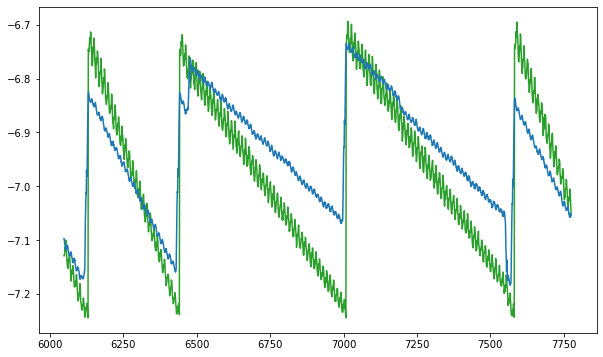

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(val_time,val_df['Pressure'],'tab:green')
plt.plot(val_time,results)

In [30]:
#print(len(val_df['Pressure']))
#print(type(val_df['Pressure'].va:-lues))
#print(val_df['Pressure'].values.shape)
#print(len(results))
#print(type(results))
#print(results.shape)
#print('........')
#print(results[:,0])
tf.keras.metrics.mean_absolute_error(val_df['Pressure'].values, results[:,0]).numpy()

0.07004846

In [31]:
results = (results * train_psi_std) + train_psi_mean
print(train_psi_mean)
print(train_psi_std)
print(results)

49.21746431057673
7.07029110962004
[[-0.96375656]
 [-0.96567154]
 [-1.0097885 ]
 ...
 [-0.67806244]
 [-0.63438034]
 [-0.64089966]]


In [32]:
print(psi[int(n*0.7):int(n*0.9)])

[40.81401356 40.85342562 40.86026137 ... 45.58475952 45.11400176
 44.61315449]


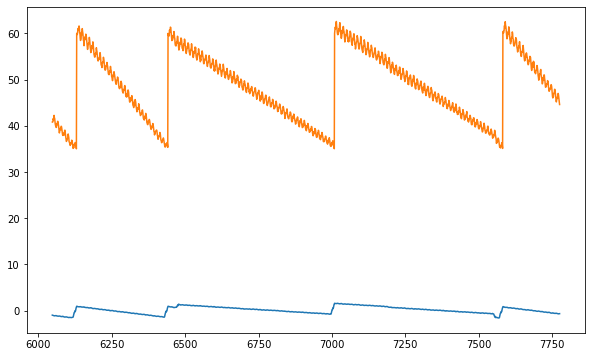

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(val_time,results)
plt.plot(val_time,psi[int(n*0.7):int(n*0.9)])
